## Table of Contents
0. Notebook Setup
1. RFM Modeling
2. Exporting Dataframes

--------------
### 0. Importing Packages/Data

In [14]:
# 0.0 - 
import pandas as pd
import numpy as np
import os
import datetime as dt
import warnings

In [15]:
# 0.1 - Set directory 
os.chdir('C:\\Users\\Bruen\\Dropbox\\My PC (DESKTOP-V41C1LD)\\Desktop\\Data Science Portfolio\\Datasets')

In [16]:
# 0.2 - Assign storedf to Superstore Excel file
# The warning is fine!
storedf = pd.read_excel('Sample - Superstore.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [17]:
# 0.3 - Checking the shape and contents of our dataframe
print(storedf.shape)
display(storedf.head())

(9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [18]:
# 0.4 - Checking NaNs. Only 11 in Postal Code (which is acceptable)
storedf.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
Quantity          0
Discount          0
Profit            0
dtype: int64

In [19]:
# 0.5 - Order Date is already a datetime - we don't need to convert it
storedf['Order Date']

0      2017-11-08
1      2017-11-08
2      2017-06-12
3      2016-10-11
4      2016-10-11
          ...    
9989   2015-01-21
9990   2018-02-26
9991   2018-02-26
9992   2018-02-26
9993   2018-05-04
Name: Order Date, Length: 9994, dtype: datetime64[ns]

-------------
### 1. RFM Modeling

In [20]:
# 1.0 - For our recency calculations, we're using our most recent purchase date as the "baseline" date
latest_date = storedf['Order Date'].max()
print(latest_date)

2018-12-30 00:00:00


In [21]:
# 1.1 - Create RFM scores by aggregating Customer ID and using 3 separate lambda functions to form a new dataframe (RFMdf)
# R is established with the difference between the current date (latest_date) and the customer ID's most recent date of purchase
# F is the number of purchases each customer ID has made, or the count of records each customer ID has in the database
# M is the sum of sales contributed by each customer ID
RFMdf = storedf.groupby('Customer ID').agg({
    'Order Date': lambda x: (latest_date - x.max()).days, #R
    'Order ID': lambda x: len(x), #F
    'Sales': lambda x: x.sum()}) #M

In [22]:
# 1.2 - Now we'll give our new columns relevant names
RFMdf.rename(columns= {'Order Date' : 'Recency',
                            'Order ID' : 'Frequency',
                            'Sales' : 'Monetary'}, inplace= True)

In [23]:
# 1.3 - Check the shape and preview the contents of RFMscores
print(RFMdf.shape)
display(RFMdf.head())

(793, 3)


,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,184,11,5563.560
AA-10375,19,15,1056.390
AA-10480,259,12,1790.512
AA-10645,55,18,5086.935
AB-10015,415,6,886.156


count     793.000000
mean      146.773014
std       186.111367
min         0.000000
25%        30.000000
50%        75.000000
75%       183.000000
max      1165.000000
Name: Recency, dtype: float64

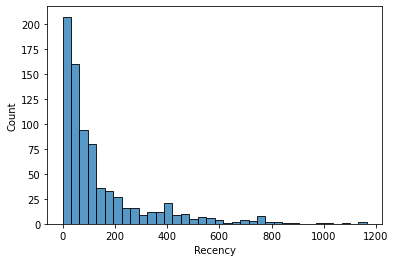

In [24]:
# 1.4 - Should we consider our recency mean to be "higher than desirable?"
# A historical comparison would give us clearer insight into that question
# This would mean that customer retention isn't our strongsuit (high churn)
# We'll save the rest of our analysis for later on in Tableau
import seaborn as sns
r = RFMdf['Recency']
ax = sns.histplot(r)
RFMdf.Recency.describe()

In [25]:
# 1.5 - Now, splitting Recency, Frequency, and Monetary into quantiles
quantiles = RFMdf.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
display(quantiles)

{'Recency': {0.25: 30.0, 0.5: 75.0, 0.75: 183.0},
 'Frequency': {0.25: 8.0, 0.5: 12.0, 0.75: 16.0},
 'Monetary': {0.25: 1146.0500000000002, 0.5: 2256.394, 0.75: 3785.276}}

In [26]:
# # 1.6 - We'll be using our aforementioned quantiles to create segments based on point values
# But first, defining "scoring" functions which will be used in the next step 
# Our most loyal/engaged/profitable customers will have a score of 444, and the least will be closer to 111
# Low recency = high R score
# Low frequency/monetary = low F/M score
def Rscore(x,y,z):
    if x <= z[y][0.25]:
        return 4
    elif x <= z[y][0.50]:
        return 3
    elif x <= z[y][0.75]:
        return 2
    else: 
        return 1

def FnMscore(x,y,z):
    if x <= z[y][0.25]:
        return 1
    elif x <= z[y][0.50]:
        return 2
    elif x <= z[y][0.75]:
        return 3
    else: 
        return 4

In [27]:
# 1.6 - Creating scored R/F/M columns by applying scoring functions to Recency/Frequency/Monetary columns
RFMdf['R'] = RFMdf['Recency'].apply(Rscore, args=('Recency', quantiles))
RFMdf['F'] = RFMdf['Frequency'].apply(FnMscore, args=('Frequency', quantiles))
RFMdf['M'] = RFMdf['Monetary'].apply(FnMscore, args=('Monetary', quantiles))

In [28]:
# 1.61 - A quick preview of our functions' results
RFMdf.head(10)

,Recency,Frequency,Monetary,R,F,M
Customer ID,,,,,,
AA-10315,184,11,5563.560,1,2,4
AA-10375,19,15,1056.390,4,3,1
AA-10480,259,12,1790.512,1,2,2
AA-10645,55,18,5086.935,3,4,4
AB-10015,415,6,886.156,1,1,1
AB-10060,54,18,7755.620,3,4,4
AB-10105,41,20,14473.571,3,4,4
AB-10150,41,12,966.710,3,2,1
AB-10165,25,14,1113.838,4,3,1


In [29]:
# 1.7 - Concatenating RFM values for a new column: RFMgroup
# And summing RFM values for another new column: RFMscore
RFMdf['RFMgroup'] = RFMdf.R.map(str) + RFMdf.F.map(str) + RFMdf.M.map(str)
RFMdf['RFMscore'] = RFMdf[['R','F','M']].sum(axis=1)
RFMdf.head()
RFMdf.reset_index(inplace=True)

In [30]:
# 1.8 - Introducing loyalty segments based on various RFM value combinations
# Then forming a new column from our Loyalty list
Loyalty = []
for i,r in RFMdf.iterrows():
        if (r['R'] == 4 and r['F'] == 4 and r['M'] == 4):
            Loyalty.append('Platinum') # Has all 4s
        elif (r['R'] >=3 and r['F'] >= 3 and r['M'] >= 3): 
            Loyalty.append('Gold') # Has at least 3 in each category
        elif (r['R'] >= 2 and r['F'] >= 2 and r['M'] >= 2) or \
             (r['R'] >= 1 and r['F'] == 4 and r['M'] >= 1):
            Loyalty.append('Silver') # Loyal customers have moderate F/M scores, represent a dependable majority
        elif (r['R'] >= 1 and r['F'] >= 2 and r['M'] == 2) or \
             (r['R'] >= 1 and r['F'] >= 2 and r['M'] == 3):
            Loyalty.append('Churn Risk') # Moderate M with low R/F
        elif (r['R'] <= 2 and r['F'] >= 1 and r['M'] >= 3):
            Loyalty.append('High-Spend') # High M and Low R/F, likely purchased with a discount/promotion
        elif (r['R'] >= 3 and r['F'] >= 1 and r['M'] >= 1):
            Loyalty.append('New') # High R, new customers
        else: 
            Loyalty.append('Churning') # Customers with the lowest R/F values
RFMdf['Loyalty'] = Loyalty

In [31]:
# 1.9 - Checkpoint: here's the count of customer ID by loyalty
RFMdf.Loyalty.value_counts()

Silver        262
Churning      160
Gold          149
New           107
Churn Risk     53
High-Spend     33
Platinum       29
Name: Loyalty, dtype: int64

--------------
### 2. Exporting Dataframes

In [32]:
# 2.0 - Merging storedf and RFMdf, then dropping unnecessary columns
storedf = storedf.merge(RFMdf, on= 'Customer ID')

In [33]:
# 2.1 - Once we're in Tableau, we'll be averaging certain measures like Profit and Discount
# This cell is just for checking some of our future Tableau calculations for correctness
storedf[['Sales', 'Quantity', 'Discount', 'Profit', 'Recency', 'Frequency', 'Monetary']].agg(['sum', 'mean']).astype(int)

,Sales,Quantity,Discount,Profit,Recency,Frequency,Monetary
sum,2297200,37873,1561,286397,1201910,156816,35915382
mean,229,3,0,28,120,15,3593


In [34]:
# 2.2 - One last checkpoint before we export and head into Tableau
print(storedf.shape)
display(storedf.head(5))

(9994, 30)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Profit,Recency,Frequency,Monetary,R,F,M,RFMgroup,RFMscore,Loyalty
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,41.9136,338,5,1148.78,1,1,2,112,4,Churning
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,219.5820,338,5,1148.78,1,1,2,112,4,Churning
2,5492,CA-2018-164098,2018-01-26,2018-01-27,First Class,CG-12520,Claire Gute,Consumer,United States,Houston,...,1.8160,338,5,1148.78,1,1,2,112,4,Churning
3,6878,US-2016-123918,2016-10-15,2016-10-15,Same Day,CG-12520,Claire Gute,Consumer,United States,Dallas,...,-95.2476,338,5,1148.78,1,1,2,112,4,Churning
4,6879,US-2016-123918,2016-10-15,2016-10-15,Same Day,CG-12520,Claire Gute,Consumer,United States,Dallas,...,1.8704,338,5,1148.78,1,1,2,112,4,Churning


In [35]:
# 2.3 - Our storedf dataframe is now ready for export
storedf.to_csv(path_or_buf= 'C:\\Users\\Bruen\\Dropbox\\My PC (DESKTOP-V41C1LD)\\Desktop\\Superstore_storedf.csv')